### Preparación básica

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from imageio import imread
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definir las dimensiones de las imágenes
IMG_WIDTH = IMG_HEIGHT = 75

In [3]:
### Carga de datos
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "train"
TEST_PATH = ROOT_PATH + "test"

# Cargar el archivo de etiquetas
train_set = pd.read_csv('train_set.csv')

# Modificar las rutas de las imágenes para que coincidan con los nombres numerados en el directorio 'train'
train_set['path'] = train_set['path'].apply(lambda x: os.path.basename(x))

# Mostrar las primeras filas del archivo modificado
print(train_set.head())

# Eliminar la columna 'path'
train_set = train_set.drop(columns=['path'])

   id_img       path  label
0       0      0.jpg  angry
1       1      1.jpg  angry
2      10     10.jpg  angry
3   10002  10002.jpg  angry
4   10016  10016.jpg  angry


In [ ]:
# Contar la cantidad de instancias por clase
class_distribution = train_set['label'].value_counts()

# Mostrar la distribución de las clases
print(class_distribution)

In [ ]:
# Visualizar la distribución de las clases
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Cantidad de imágenes')
plt.show()

In [4]:
# Definir función para leer datos
def read_data(directorio, reshape_dim=(IMG_WIDTH, IMG_HEIGHT), is_test=False):
    X = []
    y = []
    if is_test:
        for file in os.listdir(directorio):
            file_path = os.path.join(directorio, file)
            if os.path.isfile(file_path):  # Verifica si es un archivo válido
                image = imread(file_path)
                image = cv2.resize(image, reshape_dim)
                X.append(image)
                y.append('unknown')  # Valor predeterminado para y_test si no tienes etiquetas
            else:
                print(f"Warning: {file_path} is not a valid file.")
    else:
        for folder in os.listdir(directorio):
            folder_path = os.path.join(directorio, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, file)
                    if os.path.isfile(image_path):  # Verifica si es un archivo válido
                        image = imread(image_path)
                        image = cv2.resize(image, reshape_dim)
                        X.append(image)
                        y.append(folder)
                    else:
                        print(f"Warning: {image_path} is not a valid file.")
            else:
                print(f"Warning: {folder_path} is not a valid directory.")
    return np.array(X), np.array(y)

# Leer datos de entrenamiento y prueba
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH, is_test=True)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_7848\4015605727.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_7848\4015605727.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(file_path)


Shape of X_train: (28821, 75, 75)
Shape of X_test: (7066, 75, 75)
Shape of y_train: (28821,)
Shape of y_test: (7066,)


In [5]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Codificar etiquetas del conjunto de entrenamiento y validación
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Verificar las etiquetas codificadas para asegurarse de que estén en el rango correcto
print("Etiquetas codificadas únicas en el conjunto de entrenamiento:", np.unique(y_train_encoded))
print("Etiquetas codificadas únicas en el conjunto de validación:", np.unique(y_val_encoded))

Etiquetas codificadas únicas en el conjunto de entrenamiento: [0 1 2 3 4 5 6]
Etiquetas codificadas únicas en el conjunto de validación: [0 1 2 3 4 5 6]


In [6]:
# Normalizar las imágenes dividiendo por 255
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Preparación y entrenamiento modelo 1

#### Modelo

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam

# Crear el modelo más complejo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compilar el modelo con un optimizador diferente
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Asegurarse de que las imágenes estén en escala de grises y con una sola dimensión de canal
X_train_gray = np.expand_dims(X_train, axis=-1).astype('float32')
X_val_gray = np.expand_dims(X_val, axis=-1).astype('float32')
X_test_gray = np.expand_dims(X_test, axis=-1).astype('float32')

# Verificar las dimensiones de los datos
print(f"X_train_gray shape: {X_train_gray.shape}")  # Debe ser (número de imágenes de entrenamiento, 75, 75, 1)
print(f"X_val_gray shape: {X_val_gray.shape}")      # Debe ser (número de imágenes de validación, 75, 75, 1)
print(f"X_test_gray shape: {X_test_gray.shape}")    # Debe ser (7066, 75, 75, 1)
print(f"y_train_encoded shape: {y_train_encoded.shape}")  # Debe ser (número de imágenes de entrenamiento,)
print(f"y_val_encoded shape: {y_val_encoded.shape}")      # Debe ser (número de imágenes de validación,)

# Verificar la estructura del modelo
model.summary()


c:\Users\Eduardo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


X_train_gray shape: (23056, 75, 75, 1)
X_val_gray shape: (5765, 75, 75, 1)
X_test_gray shape: (7066, 75, 75, 1)
y_train_encoded shape: (23056,)
y_val_encoded shape: (5765,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,375 (1.75 MB)

 Trainable params: 456,903 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

Corregir desbalanceo

In [12]:
from imblearn.over_sampling import SMOTE

# Obtener el número original de muestras en cada clase
class_counts = pd.Series(y_train_encoded).value_counts()

# Mapear nombres de clases a etiquetas codificadas
class_to_index = {label: index for index, label in enumerate(label_encoder.classes_)}

# Crear el sampling_strategy para SMOTE ajustado
sampling_strategy = {}
for class_index, count in class_counts.items():
    if count < 7164:  # Usar 7164 como el número máximo basado en la clase 'happy'
        sampling_strategy[class_index] = 7164

# Aplicar SMOTE a las clases minoritarias
smote = SMOTE(sampling_strategy=sampling_strategy)
X_train_res, y_train_res = smote.fit_resample(X_train_gray.reshape(X_train_gray.shape[0], -1), y_train_encoded)
X_train_res = X_train_res.reshape(X_train_res.shape[0], IMG_WIDTH, IMG_HEIGHT, 1)


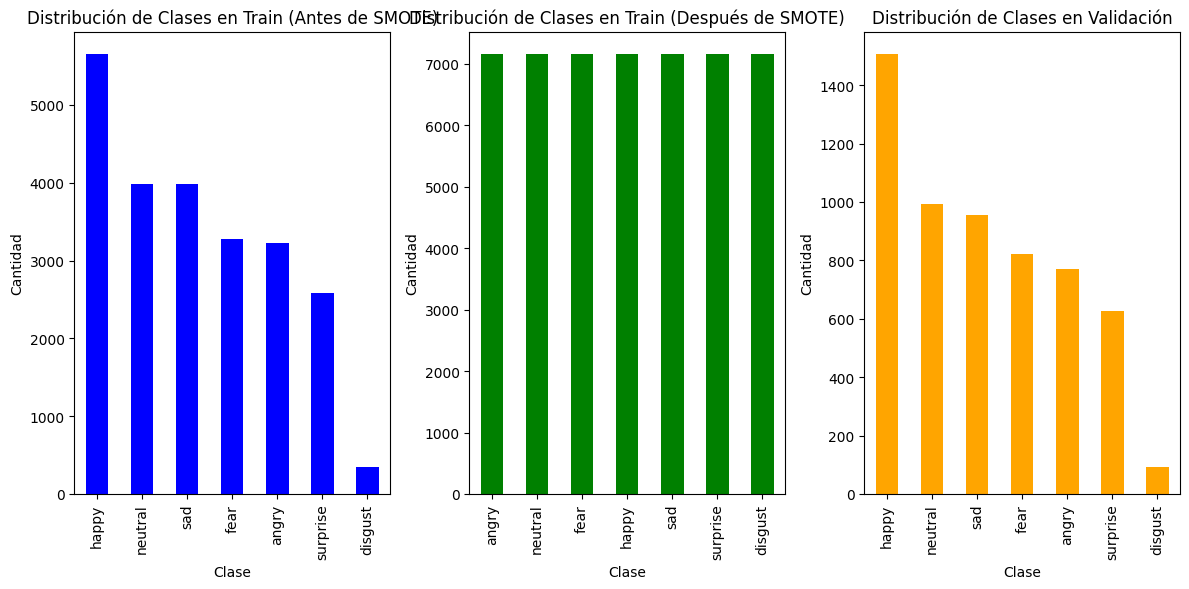

In [13]:
# Contar la cantidad de instancias por clase antes de SMOTE
class_distribution_before = pd.Series(y_train).value_counts()

# Contar la cantidad de instancias por clase después de SMote
class_distribution_after = pd.Series(label_encoder.inverse_transform(y_train_res)).value_counts()

# Contar la cantidad de instancias por clase en el conjunto de validación
class_distribution_val = pd.Series(y_val).value_counts()

# Visualizar la distribución de las clases
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
class_distribution_before.plot(kind='bar', color='blue')
plt.title('Distribución de Clases en Train (Antes de SMOTE)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 2)
class_distribution_after.plot(kind='bar', color='green')
plt.title('Distribución de Clases en Train (Después de SMOTE)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 3)
class_distribution_val.plot(kind='bar', color='orange')
plt.title('Distribución de Clases en Validación')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

In [17]:
# Callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train_res, y_train_res, batch_size=20, validation_data=(X_val_gray, y_val_encoded), epochs=20, callbacks=[early_stopping], verbose=1)


MemoryError: Unable to allocate 1.05 GiB for an array with shape (50148, 75, 75, 1) and data type float32

#### Resultados modelo 1

In [ ]:
# Graficar la evolución de la función de pérdida y la precisión
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# Predecir etiquetas del conjunto de prueba
y_test_pred = model.predict(X_test_gray)
y_test_pred_labels = label_encoder.inverse_transform(np.argmax(y_test_pred, axis=1))

# Mostrar algunas predicciones
print(f"Algunas predicciones del conjunto de prueba: {y_test_pred_labels[:10]}")

In [ ]:
# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val_gray)
y_val_pred_labels = label_encoder.inverse_transform(np.argmax(y_val_pred, axis=1))

# Generar el informe de clasificación para el conjunto de validación
val_report = classification_report(y_val_encoded, np.argmax(y_val_pred, axis=1), target_names=label_encoder.classes_)
print(val_report)

# Generar la matriz de confusión para el conjunto de validación
val_conf_matrix = confusion_matrix(y_val_encoded, np.argmax(y_val_pred, axis=1))

In [ ]:
import seaborn as sns
# Visualizar la matriz de confusión para el conjunto de validación
plt.figure(figsize=(10, 8))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()

#### Creación archivo de predicciones

In [ ]:
# Cargar el archivo test_csv que contiene la columna id_imagen
test_csv = pd.read_csv('test_set.csv')

# Predecir etiquetas del conjunto de prueba
y_test_pred = model.predict(X_test_gray)
y_test_pred_labels = label_encoder.inverse_transform(np.argmax(y_test_pred, axis=1))

# Crear un DataFrame con las predicciones
submission_df = pd.DataFrame({
    'id_img': test_csv['id_img'],
    'label': y_test_pred_labels
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('submit2_75pix_smote_modelo_mas_compl.csv', index=False)

print("Archivo .csv creado con éxito.")
